# Interacting with JetClass-II and the Sophon model

This is a self-contained notebook that

 - explores the JetClass-II dataset, and visualizes jet samples as point clouds
 - infers the Sophon model via ONNX in Python and inspects its output nodes  

If you are looking for a C++ n-tuplizer to proceed Delphes ROOT files and integrate the Sophon model, refer to [this section](https://github.com/jet-universe/sophon/tree/main?tab=readme-ov-file#c-workflow-for-analyzing-delphes-files).

This notebook is designed to [run on Google Colab](https://colab.research.google.com/github/jet-universe/sophon/blob/main/notebooks/Interacting_with_JetClassII_and_Sophon.ipynb).

## Install dependencies

In [ ]:
! pip install weaver-core
! pip install onnxruntime
#! pip install torch torchvision torchaudio # google colab has torch installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.8/886.8 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.8/638.8 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.7/342.7 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.6/179.6 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
^C


# Exploring JetClass-II

Load a few entries from JetClass-II as an example and display their data structure.

In [1]:
! wget --no-verbose https://github.com/jet-universe/sophon/raw/main/notebooks/JetClassII_example.parquet

2025-07-17 23:16:53 URL:https://raw.githubusercontent.com/jet-universe/sophon/main/notebooks/JetClassII_example.parquet [447746/447746] -> "JetClassII_example.parquet" [1]


In [2]:
import awkward as ak

arrays = ak.from_parquet("JetClassII_example.parquet")
arrays

<Array [{part_px: [...], ...}, ..., {...}] type='100 * {part_px: var * floa...'>

The entries are jet-based. Each entry includes

 - the jet features (`jet_*`),
 - the jet constituent's features (`part_*`),
 - the GEN-jet features (`genjet_*`) if a matched GEN-jet is found, and
 - the GEN-jet constituent's features (`genpart_*`).
 - auxiliary features for selected truth particles (`aux_genpart_*`)

Display the content of each branch.

In [3]:
for branch in arrays.fields:
    print(branch, ': ', arrays[branch])

part_px :  [[-202, -140, -76.9, -49.3, -44.9, ..., -0.866, -0.597, -0.563, -0.491], ...]
part_py :  [[29, -104, -2.95, -1.38, -1.01, ..., -0.175, 0.213, 0.322, 0.19, -0.253], ...]
part_pz :  [[-44, -65.4, -54.7, -34.4, -32.4, ..., -0.474, -0.289, 0.0158, -0.752], ...]
part_energy :  [[209, 186, 94.5, 60.2, 55.4, 51.3, ..., 0.954, 1.01, 0.737, 0.594, 0.933], ...]
part_deta :  [[-0.232, -0.0793, 0.215, 0.204, ..., 0.0635, -0.0315, -0.473, 0.669], ...]
part_dphi :  [[-0.251, 0.529, -0.07, -0.0804, ..., -0.349, -0.604, -0.434, 0.368], ...]
part_d0val :  [[0.00359, -0.0036, -0.0101, 0.0104, 0, -0.00337, ..., 0, 0, 0, 0, 0], ...]
part_d0err :  [[0.011, 0.011, 0.011, 0.0116, 0, 0.0116, ..., 0.0926, 0, 0, 0, 0, 0], ...]
part_dzval :  [[-0.0224, 0.0094, -0.00443, -0.0521, 0, -0.00956, ..., 0, 0, 0, 0, 0], ...]
part_dzerr :  [[0.0318, 0.0318, 0.0316, 0.0316, 0, 0.0348, ..., 0.198, 0, 0, 0, 0, 0], ...]
part_charge :  [[1, -1, 1, -1, 0, -1, 1, -1, 1, 1, 1, ..., 0, 0, 0, 0, -1, 0, 0, 0, 0, 0], ...]

# Visualizing JetClass-II

Let's visualize the jet and the matched GEN-jet as point clouds.

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

label_list = ["label_X_bb", "label_X_cc", "label_X_ss", "label_X_qq", "label_X_bc", "label_X_cs", "label_X_bq", "label_X_cq", "label_X_sq", "label_X_gg", "label_X_ee", "label_X_mm", "label_X_tauhtaue", "label_X_tauhtaum", "label_X_tauhtauh", "label_X_YY_bbbb", "label_X_YY_bbcc", "label_X_YY_bbss", "label_X_YY_bbqq", "label_X_YY_bbgg", "label_X_YY_bbee", "label_X_YY_bbmm", "label_X_YY_bbtauhtaue", "label_X_YY_bbtauhtaum", "label_X_YY_bbtauhtauh", "label_X_YY_bbb", "label_X_YY_bbc", "label_X_YY_bbs", "label_X_YY_bbq", "label_X_YY_bbg", "label_X_YY_bbe", "label_X_YY_bbm", "label_X_YY_cccc", "label_X_YY_ccss", "label_X_YY_ccqq", "label_X_YY_ccgg", "label_X_YY_ccee", "label_X_YY_ccmm", "label_X_YY_cctauhtaue", "label_X_YY_cctauhtaum", "label_X_YY_cctauhtauh", "label_X_YY_ccb", "label_X_YY_ccc", "label_X_YY_ccs", "label_X_YY_ccq", "label_X_YY_ccg", "label_X_YY_cce", "label_X_YY_ccm", "label_X_YY_ssss", "label_X_YY_ssqq", "label_X_YY_ssgg", "label_X_YY_ssee", "label_X_YY_ssmm", "label_X_YY_sstauhtaue", "label_X_YY_sstauhtaum", "label_X_YY_sstauhtauh", "label_X_YY_ssb", "label_X_YY_ssc", "label_X_YY_sss", "label_X_YY_ssq", "label_X_YY_ssg", "label_X_YY_sse", "label_X_YY_ssm", "label_X_YY_qqqq", "label_X_YY_qqgg", "label_X_YY_qqee", "label_X_YY_qqmm", "label_X_YY_qqtauhtaue", "label_X_YY_qqtauhtaum", "label_X_YY_qqtauhtauh", "label_X_YY_qqb", "label_X_YY_qqc", "label_X_YY_qqs", "label_X_YY_qqq", "label_X_YY_qqg", "label_X_YY_qqe", "label_X_YY_qqm", "label_X_YY_gggg", "label_X_YY_ggee", "label_X_YY_ggmm", "label_X_YY_ggtauhtaue", "label_X_YY_ggtauhtaum", "label_X_YY_ggtauhtauh", "label_X_YY_ggb", "label_X_YY_ggc", "label_X_YY_ggs", "label_X_YY_ggq", "label_X_YY_ggg", "label_X_YY_gge", "label_X_YY_ggm", "label_X_YY_bee", "label_X_YY_cee", "label_X_YY_see", "label_X_YY_qee", "label_X_YY_gee", "label_X_YY_bmm", "label_X_YY_cmm", "label_X_YY_smm", "label_X_YY_qmm", "label_X_YY_gmm", "label_X_YY_btauhtaue", "label_X_YY_ctauhtaue", "label_X_YY_stauhtaue", "label_X_YY_qtauhtaue", "label_X_YY_gtauhtaue", "label_X_YY_btauhtaum", "label_X_YY_ctauhtaum", "label_X_YY_stauhtaum", "label_X_YY_qtauhtaum", "label_X_YY_gtauhtaum", "label_X_YY_btauhtauh", "label_X_YY_ctauhtauh", "label_X_YY_stauhtauh", "label_X_YY_qtauhtauh", "label_X_YY_gtauhtauh", "label_X_YY_qqqb", "label_X_YY_qqqc", "label_X_YY_qqqs", "label_X_YY_bbcq", "label_X_YY_ccbs", "label_X_YY_ccbq", "label_X_YY_ccsq", "label_X_YY_sscq", "label_X_YY_qqbc", "label_X_YY_qqbs", "label_X_YY_qqcs", "label_X_YY_bcsq", "label_X_YY_bcs", "label_X_YY_bcq", "label_X_YY_bsq", "label_X_YY_csq", "label_X_YY_bcev", "label_X_YY_csev", "label_X_YY_bqev", "label_X_YY_cqev", "label_X_YY_sqev", "label_X_YY_qqev", "label_X_YY_bcmv", "label_X_YY_csmv", "label_X_YY_bqmv", "label_X_YY_cqmv", "label_X_YY_sqmv", "label_X_YY_qqmv", "label_X_YY_bctauev", "label_X_YY_cstauev", "label_X_YY_bqtauev", "label_X_YY_cqtauev", "label_X_YY_sqtauev", "label_X_YY_qqtauev", "label_X_YY_bctaumv", "label_X_YY_cstaumv", "label_X_YY_bqtaumv", "label_X_YY_cqtaumv", "label_X_YY_sqtaumv", "label_X_YY_qqtaumv", "label_X_YY_bctauhv", "label_X_YY_cstauhv", "label_X_YY_bqtauhv", "label_X_YY_cqtauhv", "label_X_YY_sqtauhv", "label_X_YY_qqtauhv", "label_QCD_bbccss", "label_QCD_bbccs", "label_QCD_bbcc", "label_QCD_bbcss", "label_QCD_bbcs", "label_QCD_bbc", "label_QCD_bbss", "label_QCD_bbs", "label_QCD_bb", "label_QCD_bccss", "label_QCD_bccs", "label_QCD_bcc", "label_QCD_bcss", "label_QCD_bcs", "label_QCD_bc", "label_QCD_bss", "label_QCD_bs", "label_QCD_b", "label_QCD_ccss", "label_QCD_ccs", "label_QCD_cc", "label_QCD_css", "label_QCD_cs", "label_QCD_c", "label_QCD_ss", "label_QCD_s", "label_QCD_light"]

def color_fader(c1, c2, mix=0): # linear interpolate from color c1 (mix=0) to c2 (mix=1)
    assert 0 <= mix <= 1
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

def visualize_jet(ax, arr, is_genjet=True):
    # part_type: 0: electron, 1: muon, 2: photon, 3: charged had, 4: neutral had
    if not is_genjet:
        jet_prefix, part_prefix = 'jet', 'part'
        part_disp = np.hypot(arr['part_d0val'], arr['part_dzval']) # an estimation of displacement
        part_type = ak.argmax([
            arr['part_isElectron'],
            arr['part_isMuon'],
            arr['part_isPhoton'],
            arr['part_isChargedHadron'],
            arr['part_isNeutralHadron']
        ], axis=0)
    else:
        jet_prefix, part_prefix = 'genjet', 'genpart'
        part_disp = np.sqrt(arr['genpart_x']**2 + arr['genpart_y']**2 + arr['genpart_z']**2)
        part_type = ak.argmax([
            abs(arr['genpart_pid']) == 11,
            abs(arr['genpart_pid']) == 13,
            arr['genpart_pid'] == 22,
            (abs(arr['genpart_pid']) == 211) | (abs(arr['genpart_pid']) == 321) | (abs(arr['genpart_pid']) == 2212),
            (arr['genpart_pid'] == 130) | (arr['genpart_pid'] == 310) | (arr['genpart_pid'] == 2112)
        ], axis=0)
    radius_fn = lambda pt: np.sqrt(pt) / 200

    # draw particles
    for i in range(arr[f"{jet_prefix}_nparticles"]):
        if not is_genjet:
            px, py, deta, dphi = map(lambda x: arr[f"part_{x}"][i], ['px', 'py', 'deta', 'dphi'])
        else:
            px, py, deta, dphi = map(lambda x: arr[f"genpart_{x}"][i], ['px', 'py', 'jet_deta', 'jet_dphi'])
        pt = np.hypot(px, py)

        color = color_fader('#74c476', '#081d58', mix=np.tanh(part_disp[i]))
        if part_type[i] == 0: # electrons
            ax.add_patch(mpl.patches.RegularPolygon((deta, dphi), 3, radius=radius_fn(pt), clip_on=True, alpha=0.3, edgecolor='black', facecolor=color))
        elif part_type[i] == 1: # muons
            ax.add_patch(mpl.patches.RegularPolygon((deta, dphi), 3, radius=radius_fn(pt), orientation=np.pi, clip_on=True, alpha=0.3, edgecolor='black', facecolor=color))
        elif part_type[i] == 2: # photons
            ax.add_patch(mpl.patches.RegularPolygon((deta, dphi), 5, radius=radius_fn(pt), clip_on=True, alpha=0.3, edgecolor=color, facecolor='none'))
        elif part_type[i] == 3: # charged hadrons
            ax.add_patch(plt.Circle((deta, dphi), radius_fn(pt), clip_on=True, alpha=0.3, facecolor=color))
        elif part_type[i] == 4: # neutral hadrons
            ax.add_patch(plt.Circle((deta, dphi), radius_fn(pt), clip_on=True, alpha=0.3, edgecolor=color, facecolor='none'))

        # if is_genjet:
        #     ax.text(deta, dphi, str(arr.genpart_pid[i]), ha='center', va='center', fontsize=4) # annotate particle PDGIDs

    # auxiliary truth particles if this is a genjet
    if is_genjet:
        for i in range(len(arr["aux_genpart_pt"])):
            color = 'yellow' if arr.aux_genpart_isResX[i] else 'gold' if arr.aux_genpart_isResY[i] else 'orange' if arr.aux_genpart_isResDecayProd[i] else None
            if color is None:
                continue
            pt = arr.aux_genpart_pt[i]
            deta = np.sign(arr.jet_eta) * (arr.aux_genpart_eta[i] - arr.jet_eta)
            dphi = (arr.aux_genpart_phi[i] - arr.jet_phi + np.pi) % (2*np.pi) - np.pi
            pid = arr.aux_genpart_pid[i]
            if abs(deta) > 0.8 or abs(dphi) > 0.8:
                continue

            # draw squares for auxiliary particles
            ax.add_patch(mpl.patches.RegularPolygon((deta, dphi), 4, radius=radius_fn(pt), clip_on=True, alpha=0.2, facecolor=color))
            ax.text(deta, dphi, str(pid), ha='center', va='center', fontsize=5) # annotate particle PDGIDs

    ax.set_xlabel(r'$\Delta\eta$'); ax.set_ylabel(r'$\Delta\phi$')
    ax.set_xlim(-0.8, 0.8); ax.set_ylim(-0.8, 0.8)
    ax.set_aspect('equal')

    # annotate basic info
    ax.text(0.02, 0.98, r'$\mathbf{%s}$ $p_{\rm T}$: %.0f GeV, $m_{\rm SD}$: %.0f GeV' % (jet_prefix, arr[f"{jet_prefix}_pt"], arr[f"{jet_prefix}_sdmass"]), ha='left', va='top', transform=ax.transAxes)
    if not is_genjet:
        ax.text(0.02, 0.91, r'truth label: %s' % label_list[arr[f"{jet_prefix}_label"]][6:], ha='left', va='top', transform=ax.transAxes)

Left subplot: jet, right subplot: matched GEN-jet

Note:
 - Hadrons = **circles**; electrons/muons = **triangles** (upward/downward); photons = **pentagons**.
 - Charged particles = **solid** markers; neutral particles = **hollow** markers.
 - Larger displacement -> more **blue**.

For GEN-jet:
 - the GEN resonances (X, Y) = **(yellow, gold) squares**; decay products = **orange squares**, PDGIDs annotated.

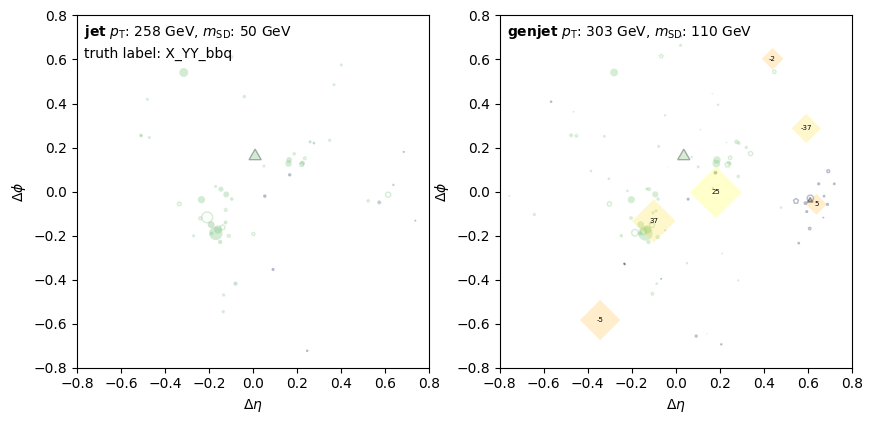

In [5]:
i = 1  # draw entry number i

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
visualize_jet(ax1, arrays[i], is_genjet=False)
visualize_jet(ax2, arrays[i], is_genjet=True)
plt.show()

# Inferring Sophon model

Download the Sophon ONNX model from Hugging Face.

In [8]:
! wget --no-verbose https://huggingface.co/jet-universe/sophon/resolve/main/models/JetClassII_Sophon/model.onnx -O JetClassII_Sophon.onnx

2025-07-17 23:18:07 URL:https://cdn-lfs-us-1.hf.co/repos/4a/b9/4ab947e5de3182c3f0fe6225553fb30b989aabcea1ec7f653a4c814f62f36c41/f54e9fd56b12e22ef4266e40b683dbf8533139b55cdab1b1c127d6e7cb8e2fd4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.onnx%3B+filename%3D%22model.onnx%22%3B&Expires=1752797886&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1Mjc5Nzg4Nn19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzRhL2I5LzRhYjk0N2U1ZGUzMTgyYzNmMGZlNjIyNTU1M2ZiMzBiOTg5YWFiY2VhMWVjN2Y2NTNhNGM4MTRmNjJmMzZjNDEvZjU0ZTlmZDU2YjEyZTIyZWY0MjY2ZTQwYjY4M2RiZjg1MzMxMzliNTVjZGFiMWIxYzEyN2Q2ZTdjYjhlMmZkND9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoifV19&Signature=H-ndHNOaGCQhSPmRvDqNjlNChmvu9uuE0z-csIKLt%7Ee%7ErS5QuqpneqN9yDyq9tFL1o38%7EdhJzvmg4weJGpEoTjB2%7EEourkCD%7EPp65i9hCIbbjxkVtitkZoN%7EjMDtnJ40ILzzWjne8PVYgPdqrSxEilsvIUW4ACSR6l3ZE0IECOPGIez9wEX9sjDEZQwfyFAsUo3LjwTW9BsjXLkpR6Vp8RgAocyZ9hfeQkrLnhYziUreDjs34kTNe8qSFC1DiHVkwTI5GbvYcTu

Start an ONNX Runtime session.

In [9]:
import onnxruntime as ort

ort_sess = ort.InferenceSession('JetClassII_Sophon.onnx')

Make input variables and do inference.

In [10]:
def make_input_feats(arr):
    # calculate all input features to the Sophon model
    input_feats = {}

    # existing variables
    for var in ['part_deta', 'part_dphi', 'part_charge', 'part_d0err', 'part_dzerr', 'part_isElectron', 'part_isMuon', 'part_isPhoton', 'part_isChargedHadron', 'part_isNeutralHadron']:
        input_feats[var] = ak.values_astype(arr[var], np.float32)
    # new variables
    input_feats['part_mask'] = ak.ones_like(arr.part_px)
    input_feats['part_px_scale'] = arr.part_px / arr.jet_pt * 500
    input_feats['part_py_scale'] = arr.part_py / arr.jet_pt * 500
    input_feats['part_pz_scale'] = arr.part_pz / arr.jet_pt * 500
    input_feats['part_energy_scale'] = arr.part_energy / arr.jet_pt * 500
    input_feats['part_pt'] = np.hypot(arr.part_px, arr.part_py)
    input_feats['part_pt_scale'] = np.hypot(input_feats['part_px_scale'], input_feats['part_py_scale'])
    input_feats['part_pt_scale_log'] = np.log(input_feats['part_pt_scale'])
    input_feats['part_e_scale_log'] = np.log(input_feats['part_energy_scale'])
    input_feats['part_logptrel'] = np.log(input_feats['part_pt'] / arr.jet_pt)
    input_feats['part_logerel'] = np.log(arr.part_energy / arr.jet_energy)
    input_feats['part_deltaR'] = np.hypot(arr.part_deta, arr.part_dphi)
    input_feats['part_d0'] = np.tanh(arr.part_d0val)
    input_feats['part_dz'] = np.tanh(arr.part_dzval)

    return input_feats


def infer_model(input_feats, debug=False):
    # define data structure and config
    input_names = ["pf_features", "pf_vectors", "pf_mask"]
    input_shapes = [(1, 17, 128), (1, 4, 128), (1, 1, 128)] # (batch_size=1, channel, length)
    input_var_info = [ # (name, subtract_val, multiply_val, clip_min, clip_max)
        [
            ("part_pt_scale_log", 1.7, 0.7, -5, 5),
            ("part_e_scale_log", 2.0, 0.7, -5, 5),
            ("part_logptrel", -4.7, 0.7, -5, 5),
            ("part_logerel", -4.7, 0.7, -5, 5),
            ("part_deltaR", 0.2, 4.0, -5, 5),
            ("part_charge", 0, 1, -1e8, 1e8),
            ("part_isChargedHadron", 0, 1, -1e8, 1e8),
            ("part_isNeutralHadron", 0, 1, -1e8, 1e8),
            ("part_isPhoton", 0, 1, -1e8, 1e8),
            ("part_isElectron", 0, 1, -1e8, 1e8),
            ("part_isMuon", 0, 1, -1e8, 1e8),
            ("part_d0", 0, 1, -1e8, 1e8),
            ("part_d0err", 0, 1, 0, 1),
            ("part_dz", 0, 1, -1e8, 1e8),
            ("part_dzerr", 0, 1, 0, 1),
            ("part_deta", 0, 1, -1e8, 1e8),
            ("part_dphi", 0, 1, -1e8, 1e8),
        ],
        [
            ("part_px_scale", 0, 1, -1e8, 1e8),
            ("part_py_scale", 0, 1, -1e8, 1e8),
            ("part_pz_scale", 0, 1, -1e8, 1e8),
            ("part_energy_scale", 0, 1, -1e8, 1e8),
        ],
        [
            ("part_mask", 0, 1, -1e8, 1e8),
        ],
    ]

    input = {name: [] for name in input_names}
    for name, shape, var_info in zip(input_names, input_shapes, input_var_info):
        if (debug):
            print("====== Preprocessed input: ", name, shape, "======")
        length = shape[-1]
        for var, sub, mul, clip_min, clip_max in var_info:
            v = ak.to_numpy(input_feats[var])
            v = (v - sub) * mul  # variable shifting and scaling
            v = np.pad(v, (0, length))[:length] # zero-padding to fixed length
            v = np.clip(v, clip_min, clip_max)  # clipping
            input[name].append(v)
            if (debug):
                print(' - ', var, v)

        input[name] = np.stack(input[name]).reshape(shape)

    # run inference
    ort_out = ort_sess.run(None, input)
    return ort_out[0][0]


In [11]:
i = 1  # infer jet entry number i

input_feats = make_input_feats(arrays[i])
output = infer_model(input_feats, debug=False)
probs, hidneurons = output[:188], output[188:]

print('Sophon model scores (len=188):', probs[:5], '...')
print('Sophon model latent features (len=128):', hidneurons[:5], '...')

Sophon model scores (len=188): [0.00087492 0.00014806 0.00021878 0.00013643 0.00019383] ...
Sophon model latent features (len=128): [-0.00624361  0.00927145 -0.02239747 -0.00590648 -0.01222859] ...


# Visualizing Sophon's output probabilities

Given a jet entry, find the top-5 probabilities interpreted by the Sophon model, and visualize these probabilities alongside the jet's visualization.

In [12]:
def visualize_top5_probs(ax, probs):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axin = inset_axes(ax, width="20%", height="20%", loc='lower right')

    top_inds = np.argsort(probs)[::-1][:5]
    axin.barh([label_list[i][6:] for i in top_inds], probs[top_inds], color='skyblue')
    axin.invert_yaxis()
    axin.xaxis.tick_top()
    axin.tick_params(axis='both', which='major', labelsize=6)
    axin.set_title('Sophon\'s\nTop-5 probs', fontsize=8)

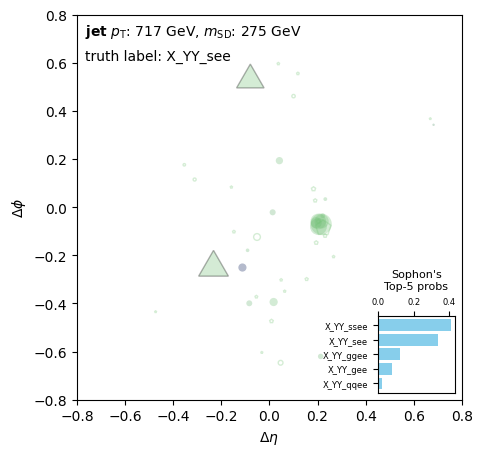

In [13]:
i = 0  # draw entry number i

# infer scores
input_feats = make_input_feats(arrays[i])
probs = infer_model(input_feats, debug=False)[:188]

# make plots
f, ax = plt.subplots(1, 1, figsize=(5, 5))
visualize_jet(ax, arrays[i], is_genjet=False)
visualize_top5_probs(ax, probs)

plt.show()